In [1]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns 
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV,  cross_val_score
from sklearn import preprocessing, linear_model
from sklearn.preprocessing import  LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import make_scorer, r2_score
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Read in the data

df = pd.read_csv('Datasets/data.csv', sep=';')

# Data cleaning

### Diagnosis

In [3]:
# Duplicate entries

print("Duplicate entry in data:",len(df[df.duplicated()])) 
df.drop_duplicates(inplace=True)

Duplicate entry in data: 0


In [4]:
def datainfo(df):
    temp_ps = pd.DataFrame(index=df.columns)
    temp_ps['DataType'] = df.dtypes
    temp_ps["Count"] = df.count()
    temp_ps['Unique values'] = df.nunique()
    temp_ps['Missing values'] = df.isnull().sum()
    temp_ps['Missing values percentage'] = (temp_ps['Missing values']/len(df))*100 
    df_desc = df.describe().transpose()
    temp_ps['Count'] = df_desc['count']
    temp_ps['Mean'] = df_desc['mean']
    temp_ps['Std'] = df_desc['std']
    temp_ps['Min'] = df_desc['min']
    temp_ps['25%'] = df_desc['25%']
    temp_ps['50%'] = df_desc['50%']
    temp_ps['75%'] = df_desc['75%']
    temp_ps['Max'] = df_desc['max']
    numerical_columns = df.select_dtypes(include=[np.number]).columns
    temp_ps['Skewness'] = df[numerical_columns].skew()
    temp_ps['Kurtosis'] = df[numerical_columns].kurtosis()
    return temp_ps

display(datainfo(df))

DataType   Count  Unique values  Missing values  \
Date                        object     NaN            365               0   
Rented Bike Count            int64  8760.0           2166               0   
Hour                         int64  8760.0             24               0   
Temperature(°C)            float64  8760.0            546               0   
Humidity(%)                  int64  8760.0             90               0   
Wind speed (m/s)           float64  8760.0             65               0   
Visibility (10m)             int64  8760.0           1789               0   
Dew point temperature(°C)  float64  8760.0            556               0   
Solar Radiation (MJ/m2)    float64  8760.0            345               0   
Rainfall(mm)               float64  8760.0             61               0   
Snowfall (cm)              float64  8760.0             51               0   
Seasons                     object     NaN              4               0   
Holiday                     object     NaN              2               0   
Functioning Day             object     NaN              2               0   

                           Missing values percentage         Mean         Std  \
Date                                             0.0          NaN         NaN   
Rented Bike Count                                0.0   704.602055  644.997468   
Hour                                             0.0    11.500000    6.922582   
Temperature(°C)                                  0.0    12.882922   11.944825   
Humidity(%)                                      0.0    58.226256   20.362413   
Wind speed (m/s)                                 0.0     1.724909    1.036300   
Visibility (10m)                                 0.0  1436.825799  608.298712   
Dew point temperature(°C)                        0.0     4.073813   13.060369   
Solar Radiation (MJ/m2)                          0.0     0.569111    0.868746   
Rainfall(mm)                                     0.0     0.148687    1.128193   
Snowfall (cm)                                    0.0     0.075068    0.436746   
Seasons                                          0.0          NaN         NaN   
Holiday                                          0.0          NaN         NaN   
Functioning Day                                  0.0          NaN         NaN   

                            Min     25%      50%      75%      Max   Skewness  \
Date                        NaN     NaN      NaN      NaN      NaN        NaN   
Rented Bike Count           0.0  191.00   504.50  1065.25  3556.00   1.153428   
Hour                        0.0    5.75    11.50    17.25    23.00   0.000000   
Temperature(°C)           -17.8    3.50    13.70    22.50    39.40  -0.198326   
Humidity(%)                 0.0   42.00    57.00    74.00    98.00   0.059579   
Wind speed (m/s)            0.0    0.90     1.50     2.30     7.40   0.890955   
Visibility (10m)           27.0  940.00  1698.00  2000.00  2000.00  -0.701786   
Dew point temperature(°C) -30.6   -4.70     5.10    14.80    27.20  -0.367298   
Solar Radiation (MJ/m2)     0.0    0.00     0.01     0.93     3.52   1.504040   
Rainfall(mm)                0.0    0.00     0.00     0.00    35.00  14.533232   
Snowfall (cm)               0.0    0.00     0.00     0.00     8.80   8.440801   
Seasons                     NaN     NaN      NaN      NaN      NaN        NaN   
Holiday                     NaN     NaN      NaN      NaN      NaN        NaN   
Functioning Day             NaN     NaN      NaN      NaN      NaN        NaN   

                             Kurtosis  
Date                              NaN  
Rented Bike Count            0.853387  
Hour                        -1.204176  
Temperature(°C)             -0.837786  
Humidity(%)                 -0.803559  
Wind speed (m/s)             0.727179  
Visibility (10m)            -0.961980  
Dew point temperature(°C)   -0.755430  
Solar Radiation (MJ/m2)      1.126433  
Rainfall(mm)               284.991099 

- We can see 4 categorical variables
- We can see 10 discrete variables

- No missing values 
- Low unique counts in last 3 columns

- Very heavy skewness on Rainfall and Snowfall will have to be treated

### Filtering

Functioning Day  Rented Bike Count
0             Yes            6172314
1              No                  0

Number of rows remaining: 8465 (96.63% of the original dataset)


<Figure size 1500x800 with 0 Axes>

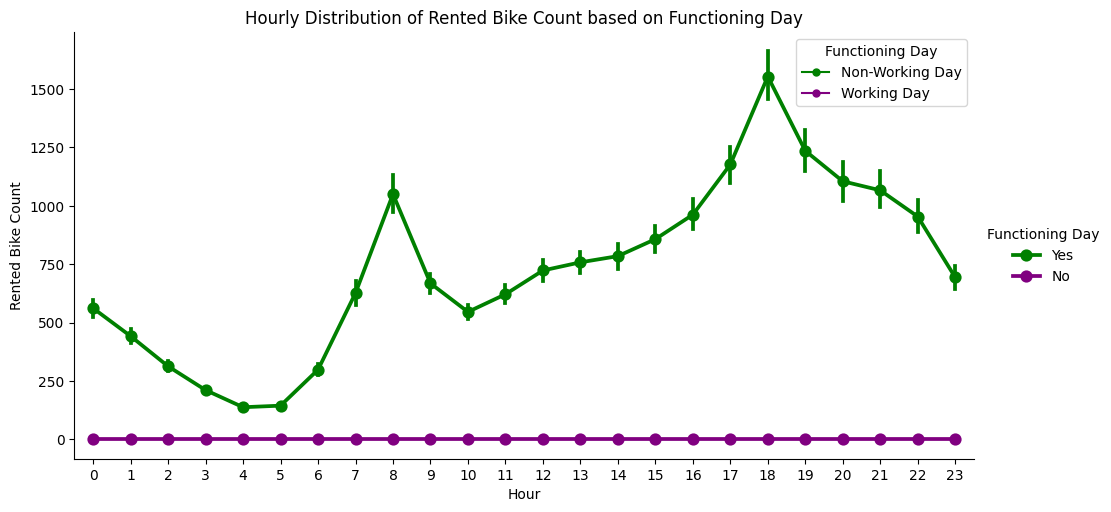

In [6]:
display(df.groupby('Functioning Day').sum()['Rented Bike Count'].sort_values(ascending = False).reset_index())

# We only have data for Functioning Day = Yes, so we can drop this column and the rows where Functioning Day = No
before = len(df)
df_filtered=df.drop(df[df['Functioning Day'] == 'No'].index) 
df_filtered.drop(['Functioning Day'], axis=1, inplace = True)

# Number of rows remaining
print("Number of rows remaining:", len(df_filtered), f"({round(len(df_filtered)/before*100,2)}% of the original dataset)")

colors = ["green", "purple"]

plt.figure(figsize=(15, 8))
sns.catplot(x='Hour', y='Rented Bike Count', hue='Functioning Day', data=df, kind='point', height=5, aspect=2, palette=colors)

plt.xlabel('Hour')
plt.ylabel('Rented Bike Count')
plt.title('Hourly Distribution of Rented Bike Count based on Functioning Day')

legend_labels = ['Non-Working Day', 'Working Day']
legend_handles = [plt.Line2D([0], [0], marker='o', color=colors[i], label=label, markersize=5) for i, label in enumerate(legend_labels)]
plt.legend(handles=legend_handles, title='Functioning Day')

plt.show()

# We can see that all non-working days are always at 0, so we can drop this column and the rows where Functioning Day = No

In [7]:
# Separate the date column into day, month and year columns

df_filtered['Date'] = pd.to_datetime(df_filtered['Date'], format='%d/%m/%Y')
df_filtered['Day'] = df_filtered['Date'].dt.day
df_filtered['Month'] = df_filtered['Date'].dt.month
df_filtered['Year'] = df_filtered['Date'].dt.year

# Create Weekend column
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df['Weekday'] = df['Date'].dt.day_name()
df['Weekday'] = pd.Categorical(df['Weekday'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
df['Weekend'] = df['Weekday'].map(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)
df.drop('Weekday', axis=1, inplace=True)

# Drop the date column

df_filtered.drop(['Date'], axis=1, inplace = True)

In [8]:
# Resulting dataframe

df_filtered.head()

Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  Wind speed (m/s)  \
0                254     0             -5.2           37               2.2   
1                204     1             -5.5           38               0.8   
2                173     2             -6.0           39               1.0   
3                107     3             -6.2           40               0.9   
4                 78     4             -6.0           36               2.3   

   Visibility (10m)  Dew point temperature(°C)  Solar Radiation (MJ/m2)  \
0              2000                      -17.6                      0.0   
1              2000                      -17.6                      0.0   
2              2000                      -17.7                      0.0   
3              2000                      -17.6                      0.0   
4              2000                      -18.6                      0.0   

   Rainfall(mm)  Snowfall (cm) Seasons     Holiday  Day  Month  Year  
0           0.0            0.0  Winter  No Holiday    1     12  2017  
1           0.0            0.0  Winter  No Holiday    1     12  2017  
2           0.0            0.0  Winter  No Holiday    1     12  2017  
3           0.0            0.0  Winter  No Holiday    1     12  2017  
4           0.0            0.0  Winter  No Holiday    1     12  2017

# Exploratory data analysis

Here we can see the graphs between all the columns of the dataframe, this allows us to have a first view of the correlations of the dataframe

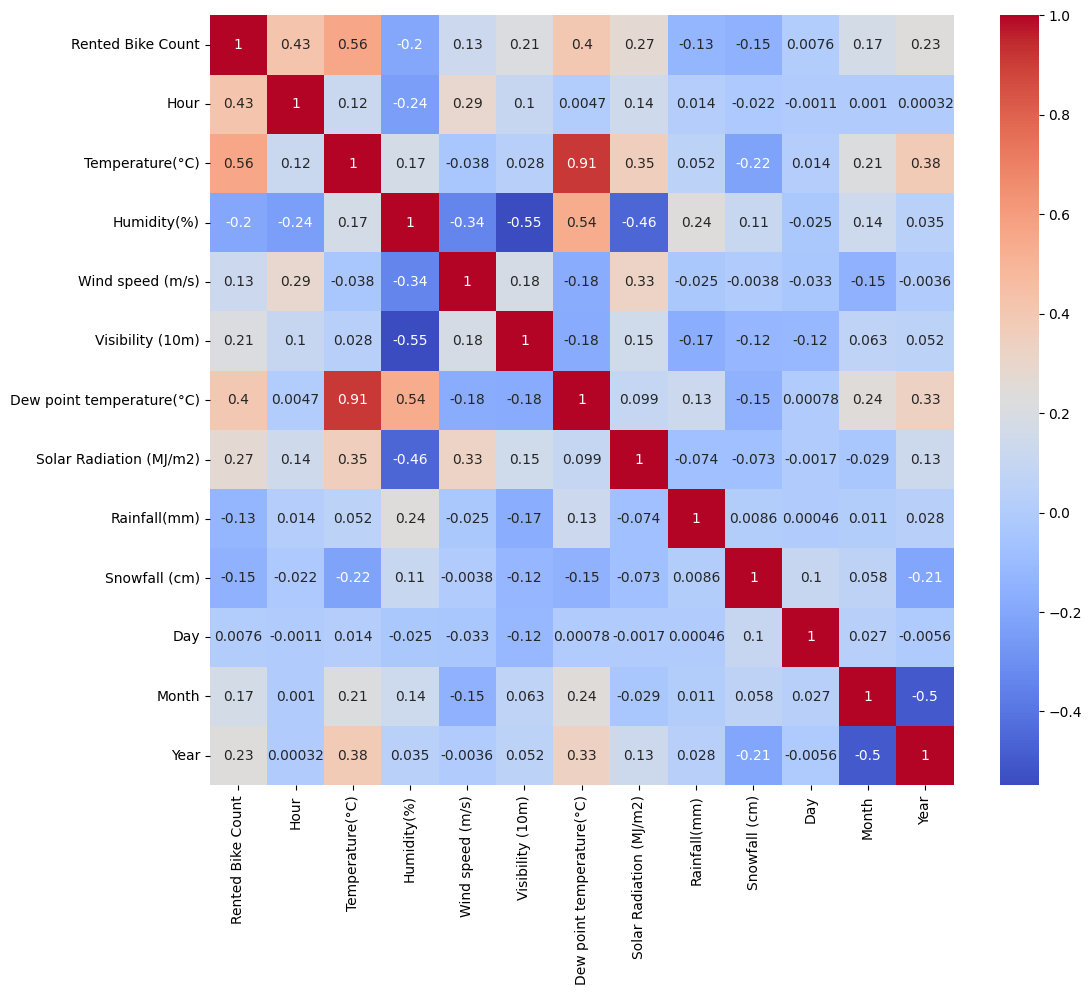

Index(['Date', 'Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day', 'Weekend'],
      dtype='object')

In [9]:
# Plotting the correlation matrix

numerical_columns = df_filtered.select_dtypes(include=[np.number]).columns
corr_matrix = df_filtered[numerical_columns].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

df.columns

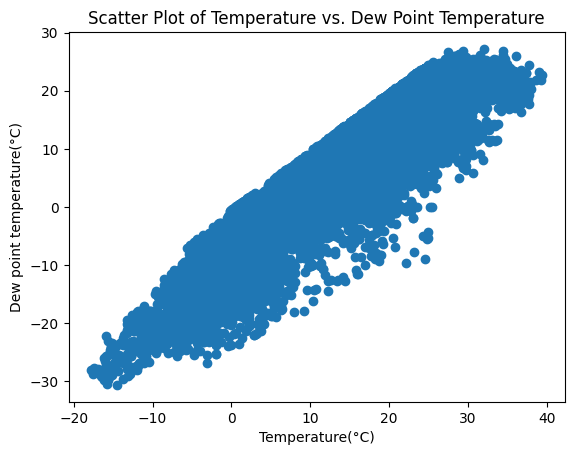

In [10]:
# Dew point temperature and temperature are very highly correlated (0.91), so we can drop one of them

df_filtered.drop(['Dew point temperature(°C)'], axis=1, inplace=True)

plt.scatter(df['Temperature(°C)'], df['Dew point temperature(°C)'])
plt.xlabel('Temperature(°C)')
plt.ylabel('Dew point temperature(°C)')
plt.title('Scatter Plot of Temperature vs. Dew Point Temperature')
plt.show()

# Feature engineering

### Encoding

In [11]:
df_encoded = df.apply(LabelEncoder().fit_transform)
df_encoded.head()

Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
0     0                253     0              111           28   
1     0                203     1              108           29   
2     0                172     2              103           30   
3     0                106     3              101           31   
4     0                 77     4              103           27   

   Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
0                22              1788                        114   
1                 8              1788                        114   
2                10              1788                        113   
3                 9              1788                        114   
4                23              1788                        104   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm)  Seasons  Holiday  \
0                        0             0              0        3        1   
1                        0             0              0        3        1   
2                        0             0              0        3        1   
3                        0             0              0        3        1   
4                        0             0              0        3        1   

   Functioning Day  Weekend  
0                1        0  
1                1        0  
2                1        0  
3                1        0  
4                1        0

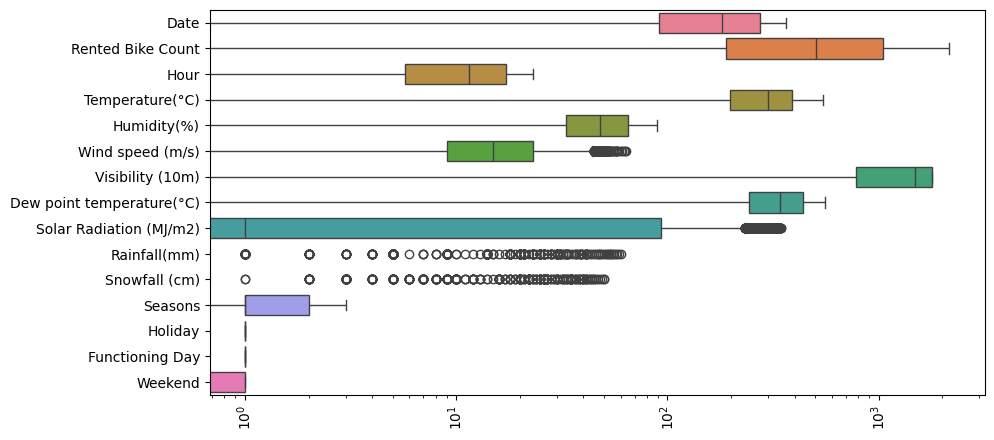

In [12]:
plt.figure(figsize=(10,5))
plt.xticks(rotation=90) 
sns.boxplot(data=df_encoded, orient='h') 
plt.xscale('log')
plt.show()

- We can see through this the variance of features.
- There a few outliers, and they are mainly in the features Rainfall and Snowfall, so treating them would lead to removing those column's value, which isnt good.

### Visualization of Rented Bike Count VS others features

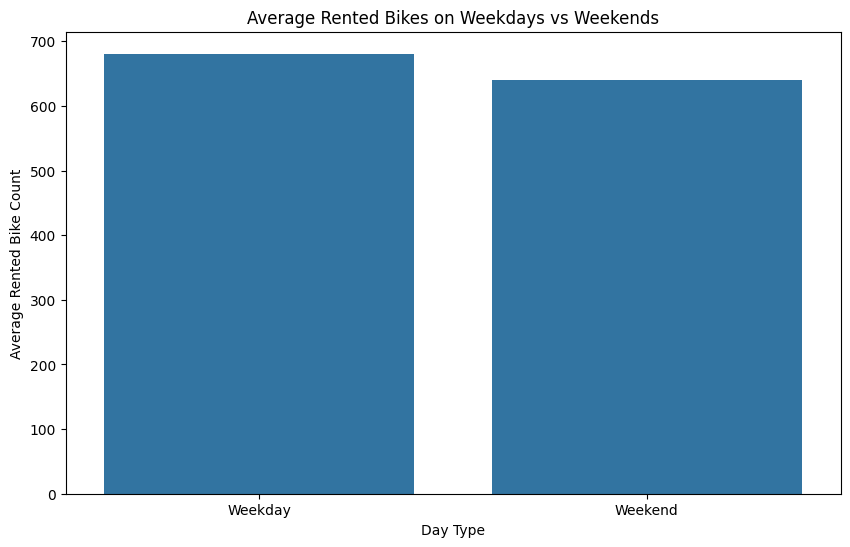

In [13]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Weekend', y='Rented Bike Count', data=df_encoded, ci=None)
plt.title('Average Rented Bikes on Weekdays vs Weekends')
plt.xlabel('Day Type')
plt.ylabel('Average Rented Bike Count')
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.show()

We can see that the difference in bikes rented between weekends and weekdays is very small so we can remove weekends from the data ("df_encoded")

In [14]:
# Drop the weekend column

df_encoded.drop(['Weekend'], axis=1, inplace = True)

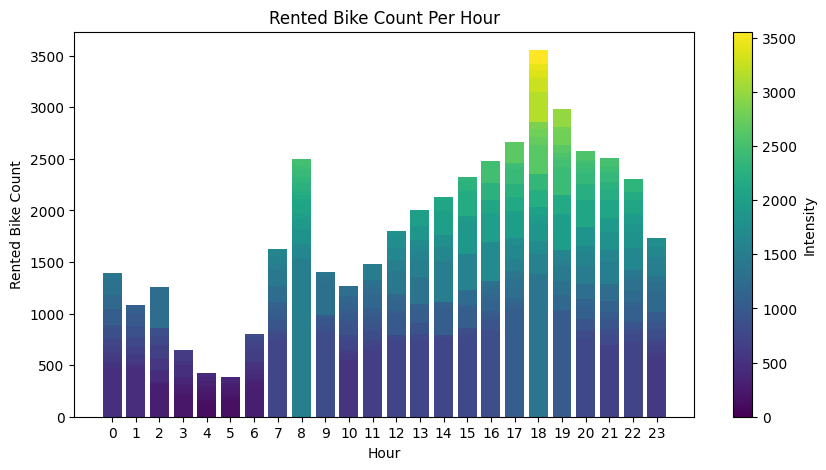

In [15]:
colors = plt.cm.viridis(df['Rented Bike Count'] / max(df['Rented Bike Count']))

plt.figure(figsize=(10, 5))
bars = plt.bar(df['Hour'], df['Rented Bike Count'], color=colors)

plt.xlabel('Hour')
plt.ylabel('Rented Bike Count')
plt.title('Rented Bike Count Per Hour')
plt.xticks(range(0, 24))

sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=df['Rented Bike Count'].min(), vmax=df['Rented Bike Count'].max()))
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('Intensity')

plt.show()

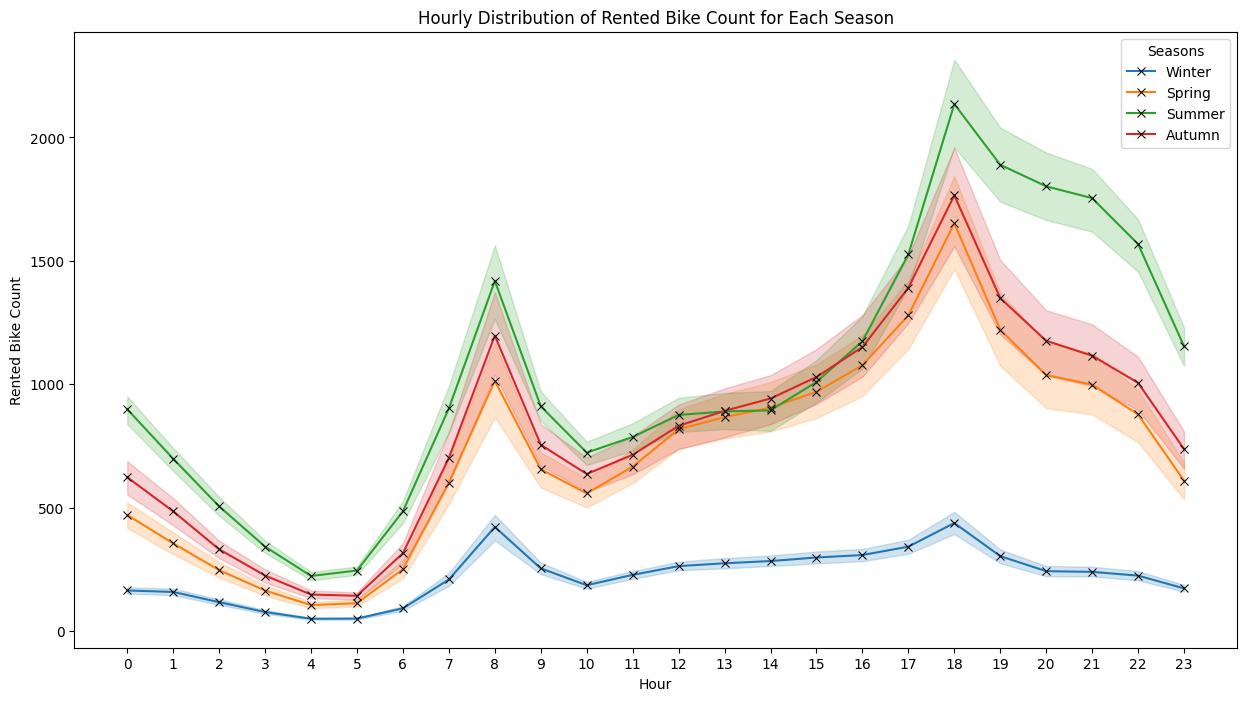

In [16]:
seasons_mapping = {1: 'Spring', 2: 'Summer', 3: 'Autumn', 4: 'Winter'}

plt.figure(figsize=(15, 8))
graph = sns.lineplot(x='Hour', y='Rented Bike Count', hue='Seasons', data=df, marker='x', markeredgecolor='black')
plt.xticks(range(0, 24))
plt.xlabel('Hour')
plt.ylabel('Rented Bike Count')
plt.title('Hourly Distribution of Rented Bike Count for Each Season')

plt.show()

The visualization shows that the values are arranged in the following order (in ascending order): Winter, Spring, Autumn, and Summer. This indicates that the demand for rented bikes tends to be lower during the winter season, followed by a gradual increase in the spring and autumn seasons. The highest values are observed during the summer season, possibly due to favorable weather conditions and increased outdoor activities. It seems that weather conditions affect the number of bike rentals

The highest peak in bike rentals occurs between 4 PM and 8 PM (6 PM is the highest), indicating a significant demand during the evening hours. A notable spike is also observed at 8 AM, suggesting a demand for bikes during the morning rush hour.This suggests that many people use bikes to commute from home to work.

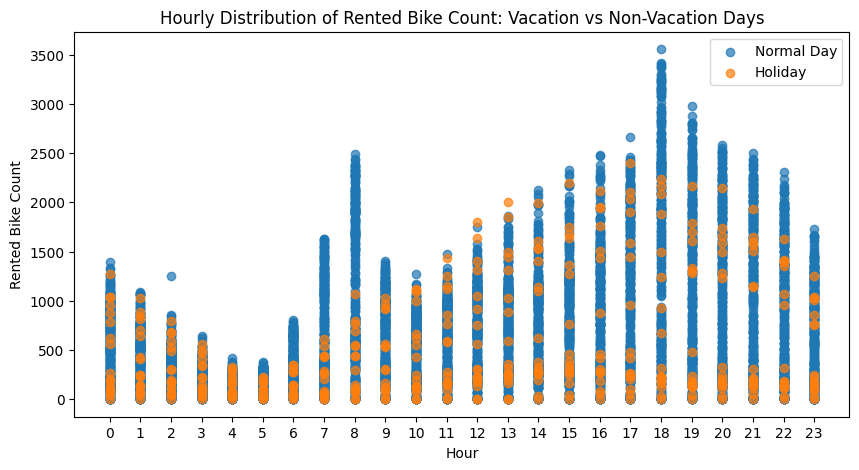

In [17]:
df_temp = df.copy()  
df_temp['Holiday_Transformed'] = df_temp['Holiday'].map({"No Holiday": 0, "Holiday": 1})

# Visualisation
plt.figure(figsize=(10, 5))
plt.scatter(df_temp[df_temp['Holiday_Transformed'] == 0]['Hour'], df_temp[df_temp['Holiday_Transformed'] == 0]['Rented Bike Count'], label='Normal Day', alpha=0.7)
plt.scatter(df_temp[df_temp['Holiday_Transformed'] == 1]['Hour'], df_temp[df_temp['Holiday_Transformed'] == 1]['Rented Bike Count'], label='Holiday', alpha=0.7)
plt.xlabel('Hour')
plt.ylabel('Rented Bike Count')
plt.title('Hourly Distribution of Rented Bike Count: Vacation vs Non-Vacation Days')
plt.xticks(range(0, 24))
plt.legend()
plt.show()

The visualization reveals that bike rental counts are generally lower during vacation periods compared to non-vacation days. This suggests that the demand for rented bikes is influenced by holidays. The lower values during vacation periods may be attributed to a variety of factors, such as people not going to work, being away on trips, etc...

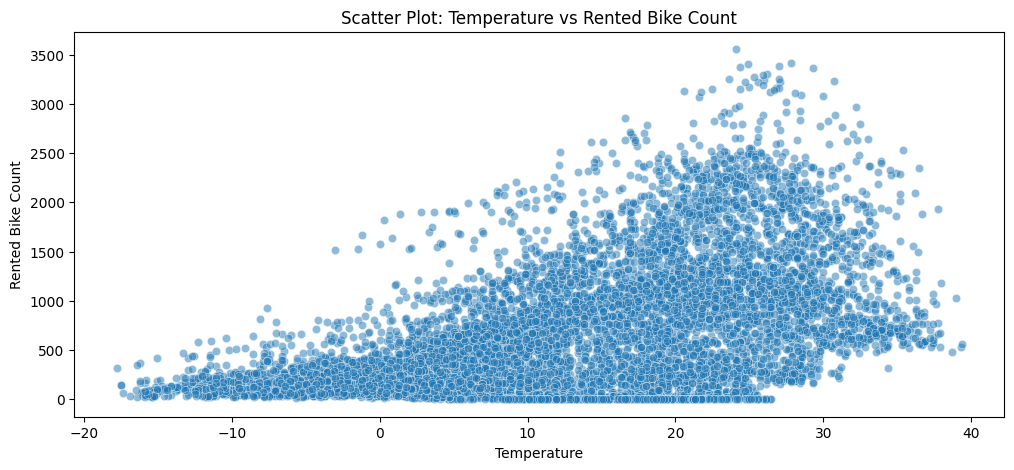

In [18]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=df['Temperature(°C)'], y=df['Rented Bike Count'], alpha=0.5)
plt.title('Scatter Plot: Temperature vs Rented Bike Count')
plt.xlabel('Temperature')
plt.ylabel('Rented Bike Count')
plt.show()

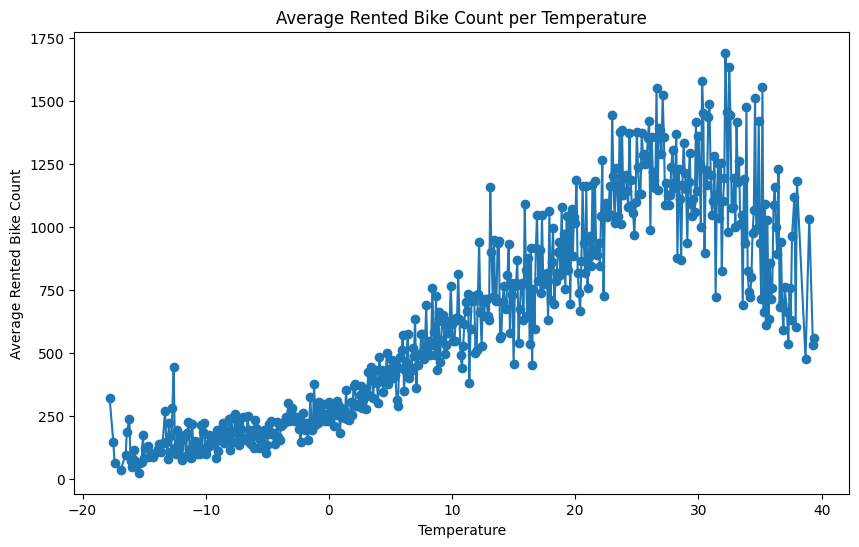

In [19]:
avg_rented_bikes_per_temp = df.groupby('Temperature(°C)')['Rented Bike Count'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(avg_rented_bikes_per_temp['Temperature(°C)'], avg_rented_bikes_per_temp['Rented Bike Count'], marker='o')
plt.title('Average Rented Bike Count per Temperature')
plt.xlabel('Temperature')
plt.ylabel('Average Rented Bike Count')
plt.show()

In the last two visualizations wen can see that the demand for bikes decreases as the temperature drops. It reaches its highest point at around 30°C.

For extremely high temperatures, a decrease in the number of rental bicycles is observed.

In [20]:
fig = px.scatter(df, x='Temperature(°C)', y='Rented Bike Count', color='Seasons', hover_data=['Humidity(%)', 'Wind speed (m/s)'], size='Rented Bike Count')
fig.update_layout(title='Overview of features')
fig.show()

This visualizations groups all we saw just before.

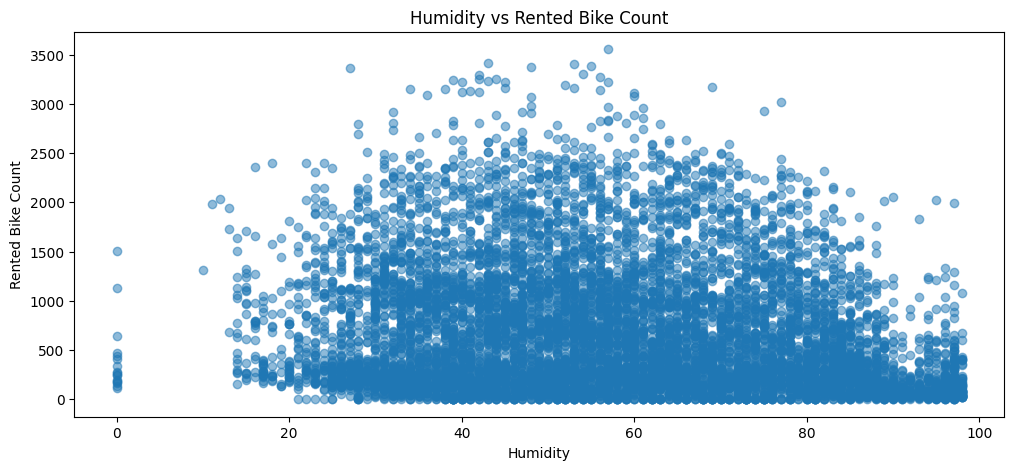

In [21]:
plt.figure(figsize=(12, 5))
plt.scatter(x=df['Humidity(%)'], y=df['Rented Bike Count'], alpha=0.5)
plt.title('Humidity vs Rented Bike Count')
plt.xlabel('Humidity')
plt.ylabel('Rented Bike Count')
plt.show()

For extreme humidity values ​​the demand for bikes seems lower

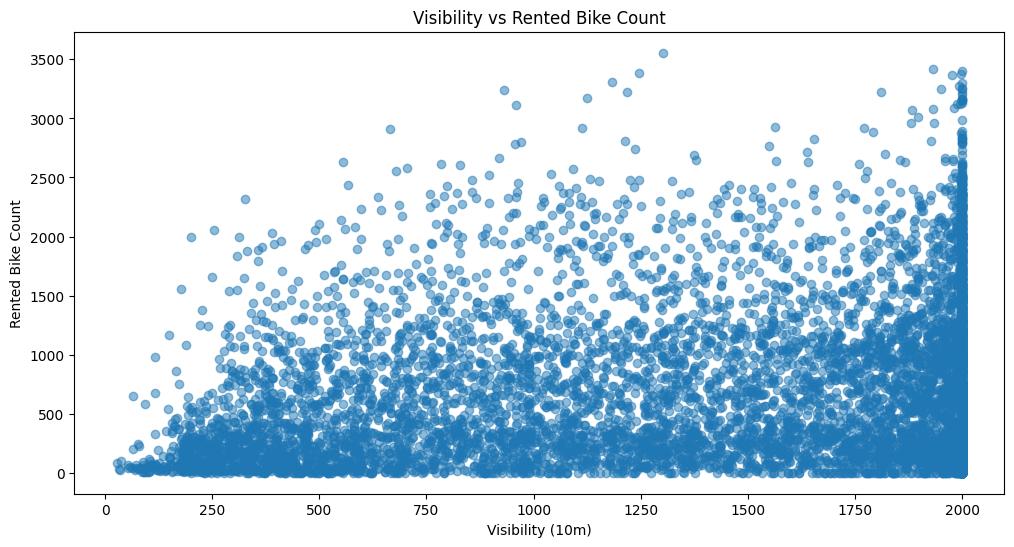

In [22]:
plt.figure(figsize=(12, 6))
plt.scatter(df['Visibility (10m)'], df['Rented Bike Count'], alpha=0.5)
plt.title('Visibility vs Rented Bike Count')
plt.xlabel('Visibility (10m)')
plt.ylabel('Rented Bike Count')
plt.show()

Quite naturally, the lower the visibility, the lower the demand for bikes.

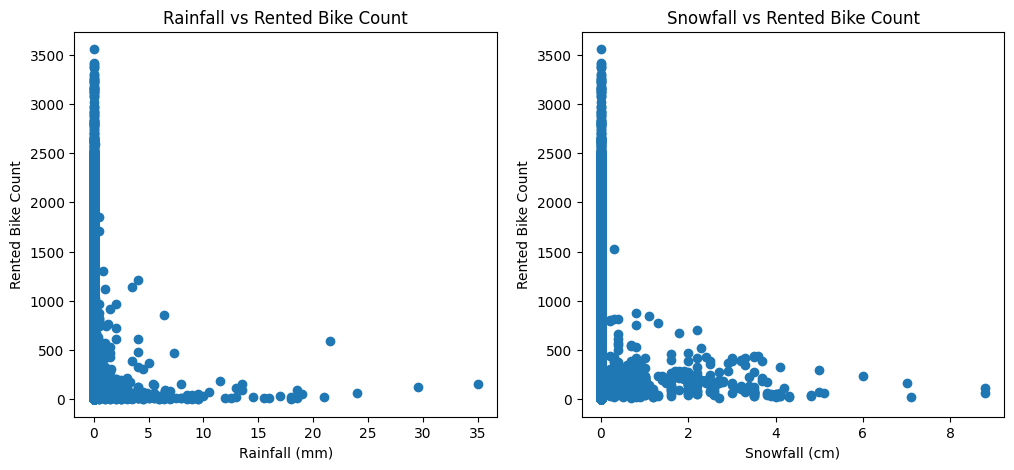

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axes[0].scatter(df['Rainfall(mm)'], df['Rented Bike Count'])
axes[0].set(xlabel='Rainfall (mm)', ylabel='Rented Bike Count', title='Rainfall vs Rented Bike Count')

axes[1].scatter(df['Snowfall (cm)'], df['Rented Bike Count'])
axes[1].set(xlabel='Snowfall (cm)', ylabel='Rented Bike Count', title='Snowfall vs Rented Bike Count')
plt.show()


Both scatter plots exhibit a similar trend, showing that lower levels of rainfall and snowfall (approaching 0 cm) correspond to higher bike rental counts. This confirms that adverse weather conditions, such as heavy rain or snow, can act as deterrents for individuals to rent bikes. When faced with inclement weather, people may opt for alternative modes of transportation activities instead.

### Regulating skewness

In [24]:
# Function to compare the skewness of the original data with the skewness of the transformed data
# Goal: to find the transformation that makes the data the most normal aka the least skewed

def compare_skew(df, column):
    fig, axes = plt.subplots(1, 4, figsize=(20,5))
    sns.distplot((df[column]), ax=axes[0]).set_title("Base data")
    sns.distplot(np.log1p(df[column]), ax=axes[1]).set_title("log1p")
    sns.distplot(np.sqrt(df[column]), ax=axes[2]).set_title("Square root")
    sns.distplot(np.cbrt(df[column]), ax=axes[3]).set_title("cube root")

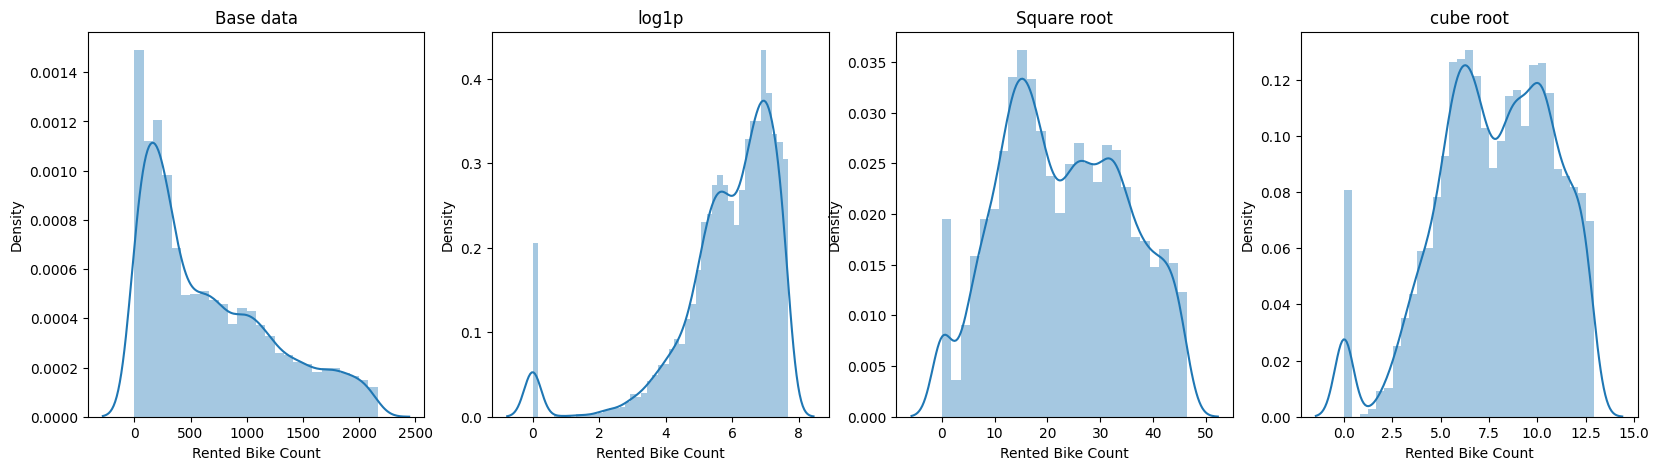

In [25]:
# On Rental Bike Count, we have a high skewness and kurtosis, so we will apply all 3 common transformations to see which one is the best
compare_skew(df_encoded, 'Rented Bike Count')

# There is a debate between the cube root and the square root transformation, but we will go with the square root
df_encoded['Rented Bike Count'] = np.sqrt(df_encoded['Rented Bike Count'])

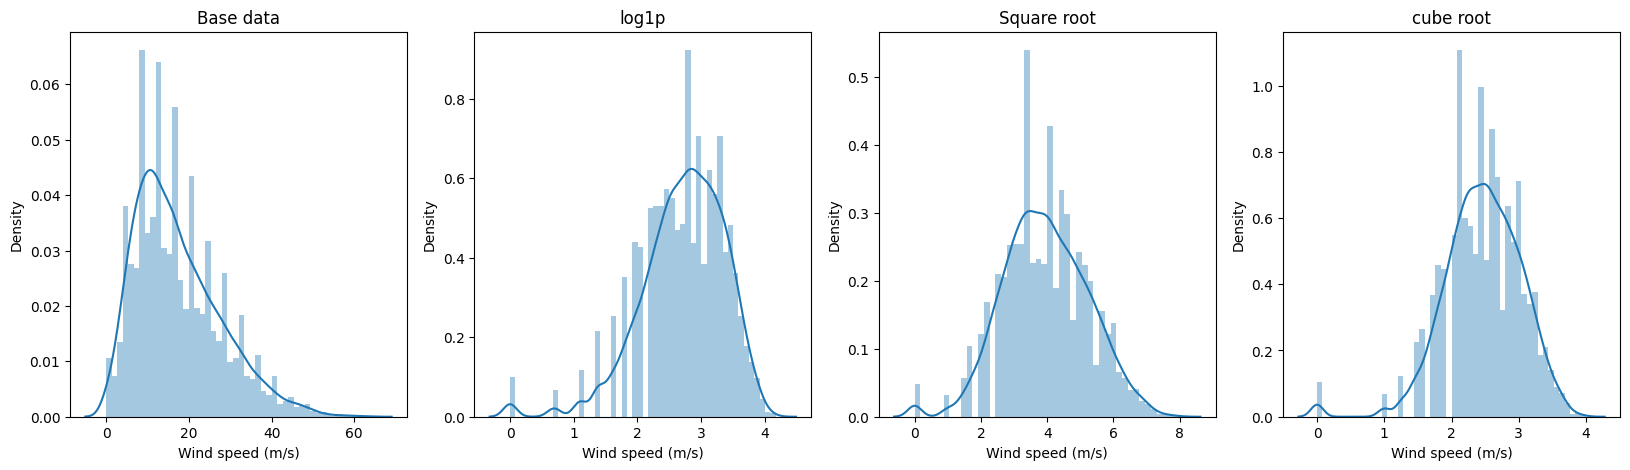

In [26]:
compare_skew(df_encoded, 'Wind speed (m/s)')

# The square root transformation is the best here
df_encoded['Wind speed (m/s)'] = np.sqrt(df_encoded['Wind speed (m/s)'])

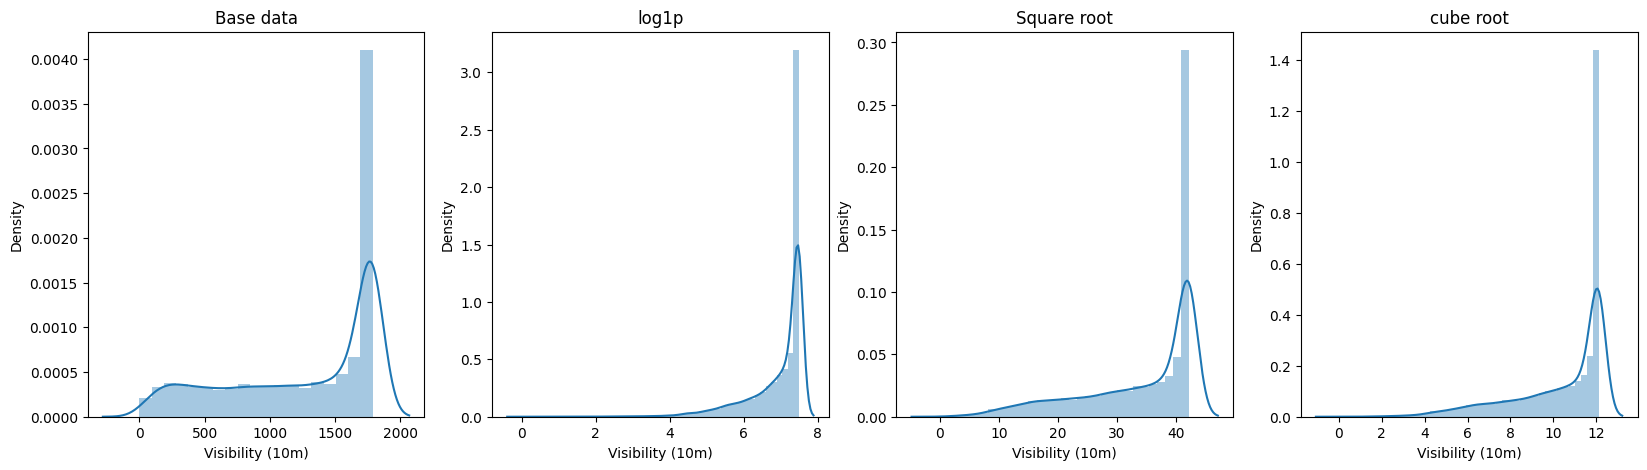

In [27]:
compare_skew(df_encoded, 'Visibility (10m)')

# No transformation can help here, which was to be expected
# We can expect the same thing from the rest of the columns with high skewness

### Defining input and output

In [28]:
X = df_encoded.drop(['Rented Bike Count'], axis=1)
y = df_encoded['Rented Bike Count']

In [29]:
# Defining train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'X_train = {X_train.shape}, X_test = {X_test.shape}')

X_train = (7008, 13), X_test = (1752, 13)


# Modeling

In [30]:
# We are trying to predict a continuous variable, so we will use regression models

In [43]:
# Function to evaluate the performance of the models

results = pd.DataFrame(columns=['Model', 'R2', 'RMSE', 'MAE'])

def train_and_evaluate(model, name, scaler=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    if scaler:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    print(name)
    print(f'R2: {r2}')
    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')

    global results
    if name not in results['Model'].values:
        results = pd.concat([results, pd.DataFrame([[name, r2, rmse, mae]], columns=['Model', 'R2', 'RMSE', 'MAE'])])

    plt.scatter(y_pred,y_test)
    plt.xlim(0, 40)
    plt.ylim(0, 40)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

Linear Regression
R2: 0.6730886140908343
RMSE: 6.728865026362392
MAE: 5.193985561979967


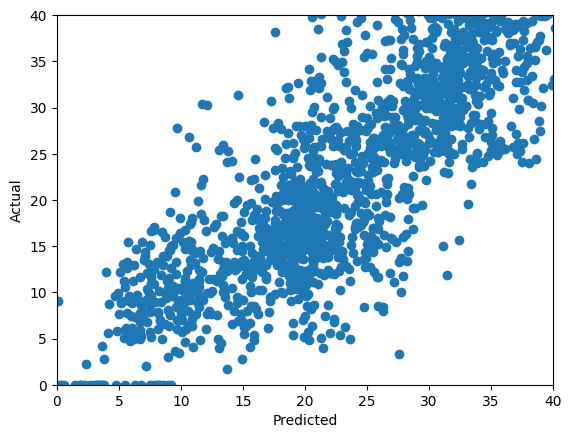

In [44]:
train_and_evaluate(LinearRegression(), 'Linear Regression')

Decision Tree
R2: 0.8207862959440224
RMSE: 4.982099554823915
MAE: 3.0621437584996807


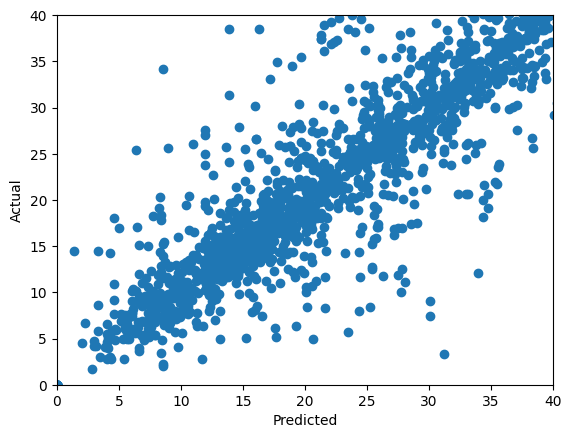

In [45]:
train_and_evaluate(DecisionTreeRegressor(), 'Decision Tree')

Random Forest GSCV SS
R2: 0.9076021863799716
RMSE: 3.5773187671768367
MAE: 2.448207278146908


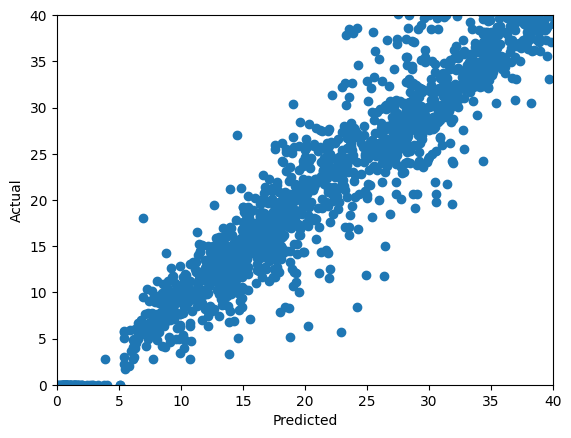

In [46]:
rf_params = {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
train_and_evaluate(RandomForestRegressor(random_state=42, **rf_params), 'Random Forest GSCV SS', StandardScaler())

In [ ]:
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf_regressor = RandomForestRegressor(random_state=42)

#GridSearchCV
rf_grid_search = GridSearchCV(rf_regressor, rf_param_grid, scoring='r2', cv=3)
rf_grid_search.fit(X_train, y_train)

#best parameters
print("Best Hyperparameters for Random Forest:", rf_grid_search.best_params_)

#Retrain the model with the best parameters
best_rf_regressor = RandomForestRegressor(random_state=42, **rf_grid_search.best_params_)
train_and_evaluate(best_rf_regressor, 'Random Forest with Best Parameters')


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1492
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 13
[LightGBM] [Info] Start training from score 23.012991
LGBM
R2: 0.9202195705634626
RMSE: 3.324106873602018
MAE: 2.269130072879223


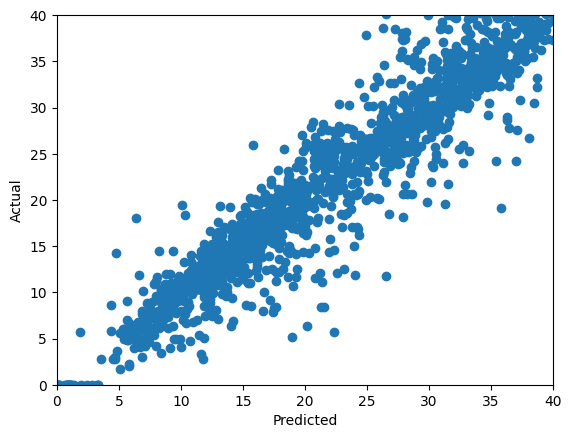

In [47]:
train_and_evaluate(LGBMRegressor(random_state=42), 'LGBM')

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5, 10, 15],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

lgbm = LGBMRegressor(random_state=42)

grid_search = GridSearchCV(lgbm, param_grid, scoring='r2', cv=3)
grid_search.fit(X_train, y_train)

#best parameters
print("Best Hyperparameters:", grid_search.best_params_)

#Retrain the model with the best parameters
best_lgbm = LGBMRegressor(random_state=42, **grid_search.best_params_)
train_and_evaluate(best_lgbm, 'LGBM with Best Parameters')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1502
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 13
[LightGBM] [Info] Start training from score 23.012991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

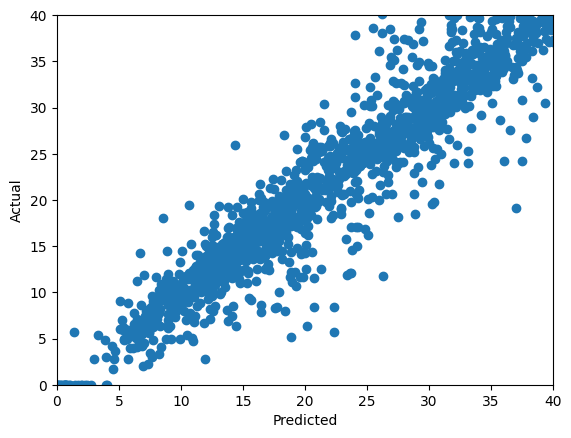

In [48]:
lgbm_params = {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}

train_and_evaluate(LGBMRegressor(random_state=42, **lgbm_params), 'LGBM GSCV SS', scaler=StandardScaler())

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1492
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 13
[LightGBM] [Info] Start training from score 23.012991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
LGBM MMS
R2: 0.9226406920637314
RMSE: 3.27327943120294

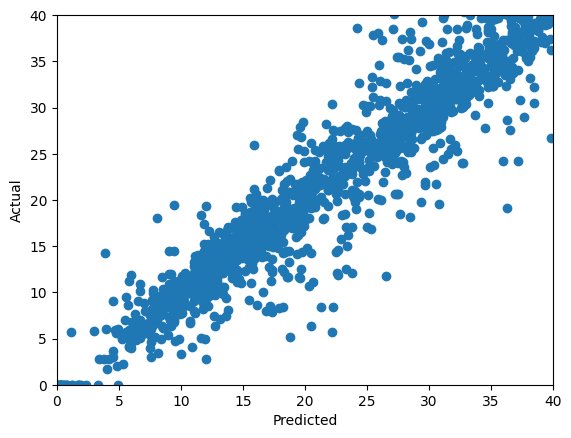

In [37]:
train_and_evaluate(LGBMRegressor(random_state=42, **lgbm_params), 'LGBM GSCV MMS', scaler=MinMaxScaler())

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1489
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 13
[LightGBM] [Info] Start training from score 23.012991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

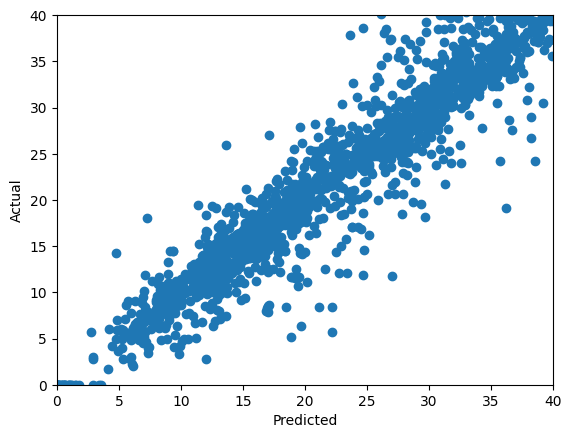

In [49]:
train_and_evaluate(LGBMRegressor(random_state=42, **lgbm_params), 'LGBM GSCV RS', scaler=RobustScaler())

SVR SS
R2: 0.7791398084689248
RMSE: 5.530768946590256
MAE: 3.9003890323763515


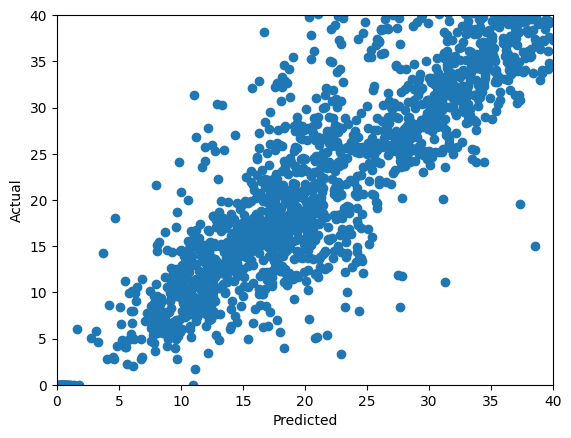

In [50]:
train_and_evaluate(SVR(), 'SVR SS', scaler=StandardScaler())

Lasso SS
R2: 0.636849700111171
RMSE: 7.092020741897397
MAE: 5.615643420019445


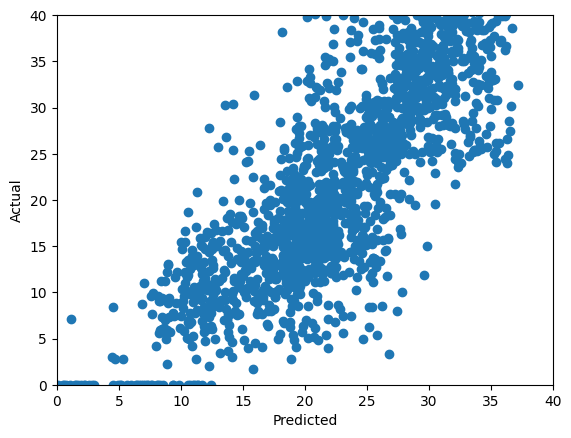

In [51]:
train_and_evaluate(Lasso(), 'Lasso SS', scaler=StandardScaler())

Ridge SS
R2: 0.67307098836927
RMSE: 6.729046420324077
MAE: 5.194290119018427


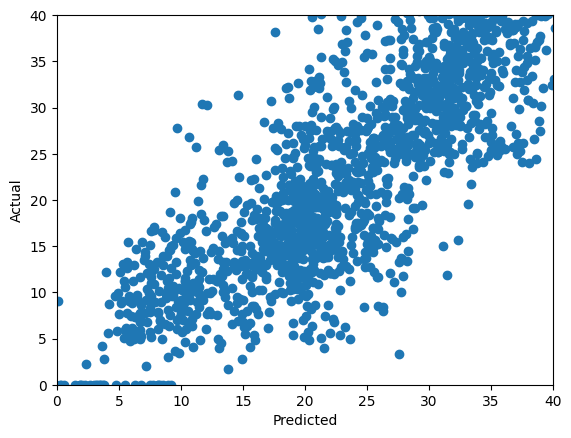

In [52]:
train_and_evaluate(Ridge(), 'Ridge SS', scaler=StandardScaler())

Gradient Boosting GSCV SS
R2: 0.9235011703461181
RMSE: 3.255023954765769
MAE: 2.110265980022594


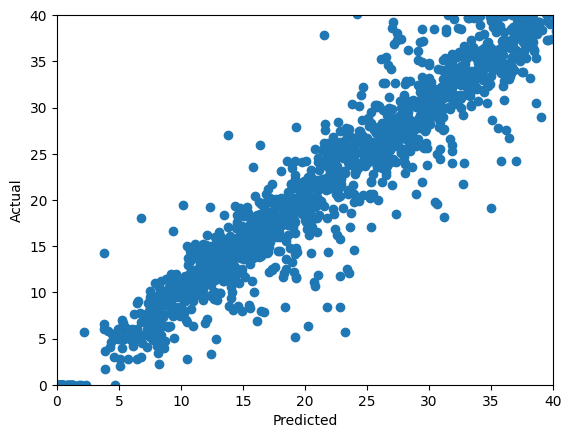

In [53]:
grad_params = {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}

train_and_evaluate(GradientBoostingRegressor(random_state=42, **grad_params), 'Gradient Boosting GSCV SS', scaler=StandardScaler())

In [ ]:
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

gb_regressor = GradientBoostingRegressor(random_state=42)

gb_grid_search = GridSearchCV(gb_regressor, gb_param_grid, scoring='r2', cv=3)
gb_grid_search.fit(X_train, y_train)

print("Best Hyperparameters for Gradient Boosting with R2:", gb_grid_search.best_params_)

best_gb_regressor_r2 = GradientBoostingRegressor(random_state=42, **gb_grid_search.best_params_)
train_and_evaluate(best_gb_regressor_r2, 'Gradient Boosting with Best Parameters (R2)')

KNN
R2: 0.5512470967145693
RMSE: 7.883706164305988
MAE: 5.5667824940376285


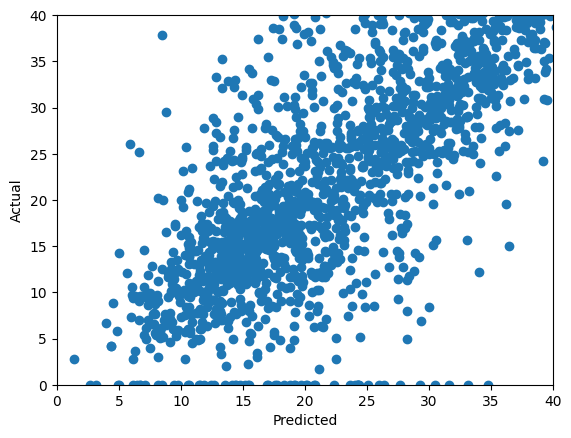

In [54]:
train_and_evaluate(KNeighborsRegressor(), 'KNN')

Extra Trees GSCV SS
R2: 0.9023500727716924
RMSE: 3.677585306208745
MAE: 2.487381406963333


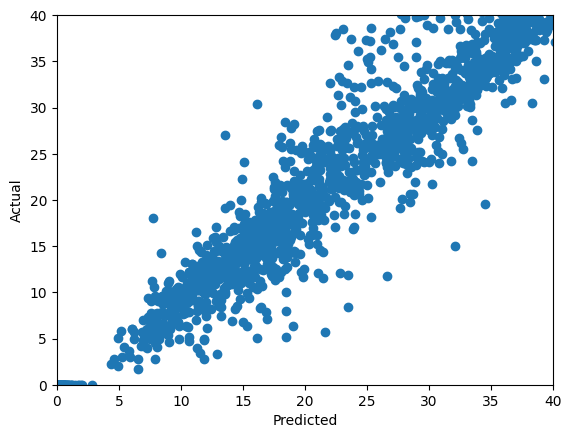

In [55]:
xt_params = {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

train_and_evaluate(ExtraTreesRegressor(random_state=42, **xt_params), 'Extra Trees GSCV SS', scaler=StandardScaler())

In [ ]:
et_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

et_regressor = ExtraTreesRegressor(random_state=42)

et_grid_search = GridSearchCV(et_regressor, et_param_grid, scoring='r2', cv=3)
et_grid_search.fit(X_train, y_train)

print("Best Hyperparameters for Extra Trees:", et_grid_search.best_params_)

best_et_regressor = ExtraTreesRegressor(random_state=42, **et_grid_search.best_params_)
train_and_evaluate(best_et_regressor, 'Extra Trees with Best Parameters')

XGBoost
R2: 0.921515138051052
RMSE: 3.2970060410026885
MAE: 2.210607544295044


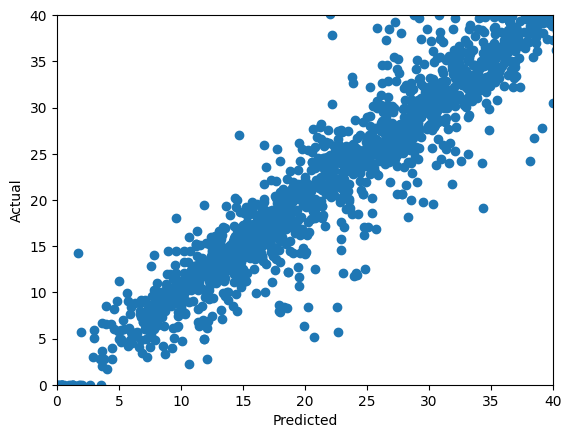

In [56]:
# XGBRegressor

from xgboost import XGBRegressor

train_and_evaluate(XGBRegressor(random_state=42), 'XGBoost')

In [ ]:
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5, 10, 15],
    'subsample': [0.8, 1.0],
}

xgb_regressor = XGBRegressor(random_state=42)

xgb_grid_search = GridSearchCV(xgb_regressor, xgb_param_grid, scoring='r2', cv=3, verbose=2)
xgb_grid_search.fit(X_train, y_train)

print("Best Hyperparameters for XGBoost with R2:", xgb_grid_search.best_params_)

best_xgb_regressor_r2 = XGBRegressor(random_state=42, **xgb_grid_search.best_params_)
train_and_evaluate(best_xgb_regressor_r2, 'XGBoost with Best Parameters (R2)')

XGBoost GSCV RS
R2: 0.9273153767161113
RMSE: 3.1728392214165715
MAE: 2.0313328412217944


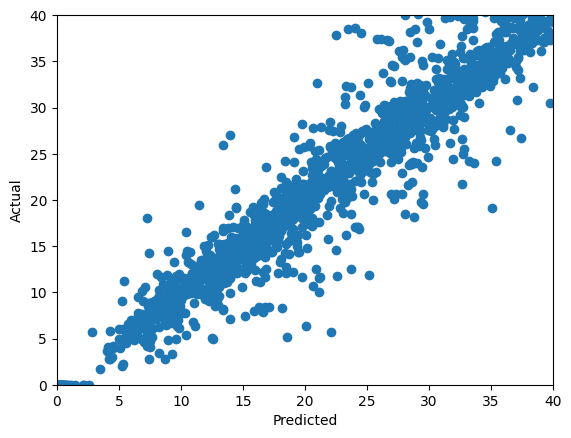

In [57]:
xgb_params = {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}
train_and_evaluate(XGBRegressor(random_state=42, **xgb_params), 'XGBoost GSCV RS', scaler=RobustScaler())

XGBoost GSCV SS
R2: 0.9273153767161113
RMSE: 3.1728392214165715
MAE: 2.0313328412217944


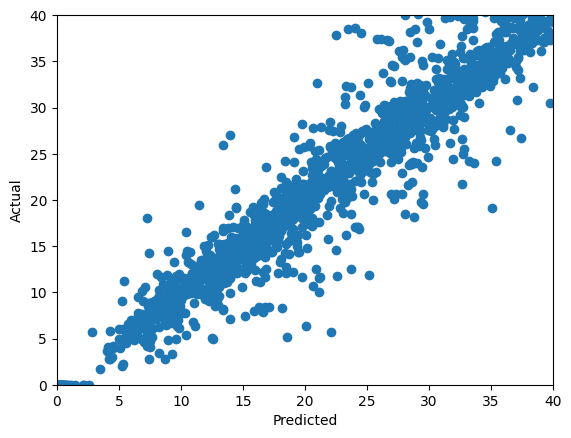

In [58]:
xgb_params = {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}
train_and_evaluate(XGBRegressor(random_state=42, **xgb_params), 'XGBoost GSCV SS', scaler=StandardScaler())

XGBoost GSCV MMS
R2: 0.9273153767161113
RMSE: 3.1728392214165715
MAE: 2.0313328412217944


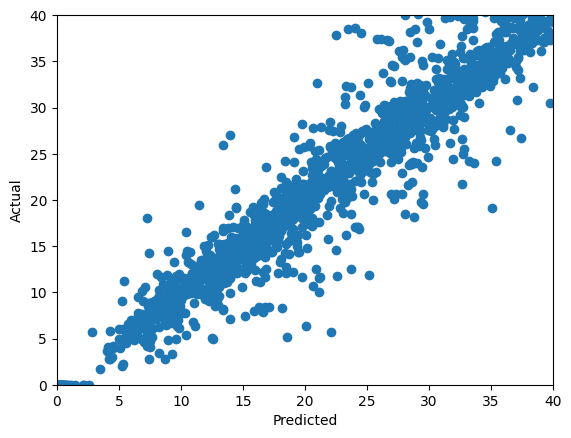

In [59]:
xgb_params = {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}
train_and_evaluate(XGBRegressor(random_state=42, **xgb_params), 'XGBoost GSCV MMS', scaler=MinMaxScaler())

In [60]:
display(results.sort_values(by='R2', ascending=False))

Model        R2      RMSE       MAE
0            XGBoost GSCV RS  0.927315  3.172839  2.031333
0            XGBoost GSCV SS  0.927315  3.172839  2.031333
0           XGBoost GSCV MMS  0.927315  3.172839  2.031333
0  Gradient Boosting GSCV SS  0.923501  3.255024  2.110266
0               LGBM GSCV RS  0.922104  3.284610  2.197318
0               LGBM GSCV SS  0.922003  3.286746  2.198099
0                    XGBoost  0.921515  3.297006  2.210608
0                       LGBM  0.920220  3.324107  2.269130
0      Random Forest GSCV SS  0.907602  3.577319  2.448207
0        Extra Trees GSCV SS  0.902350  3.677585  2.487381
0              Decision Tree  0.820786  4.982100  3.062144
0                     SVR SS  0.779140  5.530769  3.900389
0          Linear Regression  0.673089  6.728865  5.193986
0                   Ridge SS  0.673071  6.729046  5.194290
0                   Lasso SS  0.636850  7.092021  5.615643
0                        KNN  0.551247  7.883706  5.566782